In [2]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [3]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_feature_0529_norm.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,1.390,2.062,1.980,1.975,1.896,1.928,1.882,1.568,1.227,1.828,1.575,2.338,1.326,2.126,NaN,1.335,1.136,1.808,1.173,2.097,NaN,1.748,NaN,1.230,0.887,1.954,1.554,1.663,1.130,2.058,NaN,1.344,1.077,2.016,1.678,NaN,1.378,NaN,2.238,1.398
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,1.411,2.094,1.990,2.005,1.902,1.947,1.916,1.545,1.233,1.853,1.580,2.326,1.287,2.111,NaN,1.302,1.203,1.905,1.257,2.096,NaN,1.731,NaN,1.225,0.892,1.990,1.585,1.758,1.171,2.085,NaN,1.316,1.081,2.076,1.723,NaN,1.399,NaN,2.277,1.375
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,0.425,0.468,0.103,0.818,0.243,0.401,-0.257,0.243,1.233,1.237,1.110,0.390,1.633,-0.085,NaN,0.645,-0.110,1.016,1.521,0.093,NaN,0.667,NaN,0.481,1.145,0.696,0.963,0.973,1.262,0.080,NaN,0.440,1.584,1.169,0.821,NaN,1.323,NaN,-0.209,0.514
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,0.535,0.650,0.311,1.004,0.355,0.423,-0.260,0.293,1.239,1.420,1.261,0.485,1.719,-0.043,NaN,0.644,0.063,1.342,1.911,0.083,NaN,0.660,NaN,0.581,1.136,0.829,1.091,1.118,1.327,-0.002,NaN,0.463,1.607,1.408,1.054,NaN,1.488,NaN,-0.181,0.539
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,-0.905,-0.808,-0.649,-0.051,-0.960,-1.142,-1.254,-0.986,-0.986,-0.688,-0.744,-0.454,-0.600,-1.121,NaN,-1.136,-1.086,-0.706,-0.376,-0.965,NaN,-1.311,NaN,-1.033,-0.986,-0.944,-0.738,-0.269,-0.997,-1.182,NaN,-0.956,-1.133,-0.800,-0.735,NaN,-0.756,NaN,-1.374,-1.089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,2.340,2.772,2.077,2.699,2.173,2.724,2.559,1.704,2.190,2.655,1.838,2.159,1.572,2.181,NaN,1.503,3.214,3.521,2.520,2.442,NaN,1.579,NaN,2.171,2.152,3.157,2.291,3.047,1.898,2.714,NaN,1.411,2.389,3.121,2.806,NaN,2.094,NaN,2.726,1.675
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,-0.442,-0.692,-0.653,-0.289,-0.518,-0.454,-0.900,-0.701,-0.476,-0.811,-0.623,-0.503,-0.229,-0.569,NaN,-0.662,0.435,-0.592,-0.613,-0.740,NaN,-0.422,NaN,-0.401,-0.583,-0.885,-0.778,-0.403,-0.969,-0.667,NaN,-0.700,-0.395,-0.853,-0.732,NaN,-0.705,NaN,-0.555,-0.637
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.026,-0.156,0.190,0.085,0.238,0.346,-0.599,-0.131,0.557,0.220,0.750,-0.166,1.155,-0.130,NaN,0.258,0.585,0.190,1.309,-0.005,NaN,0.694,NaN,0.312,0.870,0.181,0.972,-0.029,1.078,-0.083,NaN,0.099,1.263,0.912,1.407,NaN,1.855,NaN,0.355,0.310
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.131,-0.177,-0.151,

In [4]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [5]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

data_split_dict['high'] = MPRA_df[cell_types].mean(axis=1) > 1


# MPRA_df['std'] = MPRA_df[cell_types].std(axis=1, skipna=True)
# threshold = np.percentile(MPRA_df['std'].dropna(), 95)
# data_split_dict['diff'] = (MPRA_df['std'] > threshold)
# data_split_dict['const'] = ~data_split_dict['diff']





# 计算每条序列在不同细胞类型中的最大值和最小值之差
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
# 计算 range 的第95百分位
threshold = np.percentile(MPRA_df['range'].dropna(), 95)
# 前5%的高差值序列为 diff，其余为 const
data_split_dict['diff'] = MPRA_df['range'] > threshold
data_split_dict['const'] = ~data_split_dict['diff']






# for cell_type in cell_types:
#     # 计算该细胞类型与所有细胞类型平均值的偏差
#     deviation = (MPRA_df[cell_type] - MPRA_df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)) # 只考虑特异性激活的5%
#     # plt.figure()
#     # sns.histplot(deviation)
#     threshold = np.percentile(deviation.dropna(), 95)
#     data_split_dict[f'{cell_type}_specific'] = (deviation >= threshold) & (MPRA_df[cell_type] > 1.0)



for cell_type in cell_types:
    # 计算该细胞类型与所有细胞类型平均值的偏差
    deviation = (MPRA_df[cell_type] - MPRA_df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)).abs()
    # plt.figure()
    # sns.histplot(deviation)
    threshold = np.percentile(deviation.dropna(), 95)
    data_split_dict[f'{cell_type}_specific'] = (deviation >= threshold)





for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
high 79000
diff 38034
const 722645
K562_specific 38034
HepG2_specific 38034
SK-N-SH_specific 38034
HCT116_specific 22406
A549_specific 15975


In [9]:
# 原始数据之间的相关性

for data_split in ['total', 'train', 'valid', 'test', 'diff', 'specific']:
    corr_matrix = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            if 'specific' in data_split:
                condition = data_split_dict[f'{cell_type}_specific']
            else:
                condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_matrix.loc[f'{cell_type}', f'{cell_type_2}'] = r
    print(data_split)
    print(corr_matrix)

total
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.801    0.759   0.825 0.724
HepG2   0.801  1.000    0.836   0.879 0.730
SK-N-SH 0.759  0.836    1.000   0.833 0.777
HCT116  0.825  0.879    0.833   1.000 0.825
A549    0.724  0.730    0.777   0.825 1.000
train
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.803    0.761   0.826 0.726
HepG2   0.803  1.000    0.838   0.881 0.733
SK-N-SH 0.761  0.838    1.000   0.835 0.779
HCT116  0.826  0.881    0.835   1.000 0.829
A549    0.726  0.733    0.779   0.829 1.000
valid
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.791    0.755   0.817 0.729
HepG2   0.791  1.000    0.827   0.871 0.717
SK-N-SH 0.755  0.827    1.000   0.821 0.776
HCT116  0.817  0.871    0.821   1.000 0.798
A549    0.729  0.717    0.776   0.798 1.000
test
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.785    0.745   0.817 0.698
HepG2   0.785  1.000    0.819   0.870 0.712
SK-N-SH 0.745  0.819    1.000   0.819 0.757
HCT116  0

# activity vs VEFs

In [10]:
# 原始数据之间的相关性

for assay in assays:
    for data_split in ['total', 'train', 'valid', 'test', 'test+diff', 'specific']:
        corr_matrix = pd.DataFrame()
        for cell_type in cell_types:
            for cell_type_2 in cell_types:
                if 'specific' in data_split:
                    condition = data_split_dict[f'{cell_type}_specific']
                else:
                    condition = data_split_dict[data_split]
                df = MPRA_df[condition]
                x = df[f'{cell_type}']
                y = df[f'{cell_type_2}_{assay}']
                r, p = pearson(x, y)
                corr_matrix.loc[f'{cell_type}', f'{cell_type_2}_{assay}'] = r
        print(data_split)
        print(corr_matrix)

total
         K562_DNase  HepG2_DNase  SK-N-SH_DNase  HCT116_DNase  A549_DNase
K562          0.535        0.400          0.410         0.445       0.427
HepG2         0.522        0.483          0.451         0.482       0.476
SK-N-SH       0.469        0.384          0.420         0.420       0.415
HCT116        0.492        0.431          0.437         0.483       0.454
A549          0.362        0.302          0.280         0.363       0.347
train
         K562_DNase  HepG2_DNase  SK-N-SH_DNase  HCT116_DNase  A549_DNase
K562          0.538        0.402          0.413         0.448       0.430
HepG2         0.526        0.486          0.455         0.485       0.479
SK-N-SH       0.472        0.388          0.424         0.424       0.419
HCT116        0.495        0.433          0.441         0.485       0.456
A549          0.366        0.306          0.283         0.367       0.351
valid
         K562_DNase  HepG2_DNase  SK-N-SH_DNase  HCT116_DNase  A549_DNase
K562          0.529 

# epi based model
# train on 3 cell types

# only seq based model
# train on 3 cell types

In [10]:
cell_types = ['K562', 'HepG2', 'SK-N-SH']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

# y_pred = np.load(f'../saved/0422_GosaiMPRA_MyResTransformer3_seq/0421_122831/Gosai_MPRA_pred.npy')
y_pred = np.load(f'../saved/0529_Gosai_MPRA_MyResTransformer3_seq/0530_032132/Gosai_MPRA_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred


# 使用相似的细胞类型的预测值

MPRA_df['HCT116_pred'] = MPRA_df['HepG2_pred']
MPRA_df['A549_pred'] = MPRA_df['SK-N-SH_pred']

In [11]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']

for data_split in ['train', 'valid', 'test', 'test+diff']:
    corr_matrix = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            if data_split == 'specific' or data_split == 'high':
                condition = data_split_dict[f'{cell_type}_{data_split}']
            else:
                condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_matrix.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split)
    print(corr_matrix)

train
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.952       0.826         0.796        0.826      0.796
HepG2        0.835       0.954         0.866        0.954      0.866
SK-N-SH      0.795       0.860         0.945        0.860      0.945
HCT116       0.853       0.876         0.851        0.876      0.851
A549         0.744       0.761         0.803        0.761      0.803
valid
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.862       0.759         0.732        0.759      0.732
HepG2        0.757       0.854         0.773        0.854      0.773
SK-N-SH      0.726       0.778         0.847        0.778      0.847
HCT116       0.783       0.802         0.766        0.802      0.766
A549         0.694       0.688         0.727        0.688      0.727
test
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.856       0.751         0.724        0.751      0.724
HepG2        0.75

# only seq based model
# train on 5 cell types

In [12]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']


# y_pred = np.load(f'../saved/0414_GosaiMPRA_seq_5_cell_type/0414_114350/Gosai_MPRA_pred.npy')
y_pred = np.load(f'../saved/0529_Gosai_MPRA_MyResTransformer5_seq/0530_032222/Gosai_MPRA_pred.npy')

cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [13]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'test+diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_pred in cell_types_pred:
            if data_split == 'specific' or data_split == 'high':
                condition = data_split_dict[f'{cell_type}_{data_split}']
            else:
                condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_pred}']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_pred] = r
    print(data_split)
    print(corr_matrix)

train
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.960      0.825        0.794       0.844     0.815
HepG2       0.826      0.963        0.865       0.881     0.822
SK-N-SH     0.786      0.860        0.953       0.844     0.863
HCT116      0.858      0.889        0.863       0.962     0.861
A549        0.752      0.772        0.828       0.798     0.931
valid
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.863      0.757        0.728       0.764     0.746
HepG2       0.747      0.858        0.769       0.783     0.717
SK-N-SH     0.718      0.779        0.850       0.749     0.762
HCT116      0.778      0.804        0.765       0.864     0.766
A549        0.692      0.687        0.726       0.695     0.799
test
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.858      0.751        0.721       0.759     0.734
HepG2       0.739      0.856        0.771       0.781     0.724
SK-N-SH     0.707      

# seq epi based model
# trained on 3 cell types

# CNN

In [14]:
# cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
# assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

# y_pred = np.load(f'../saved/0530_Gosai_MPRA_MyResNet_seq_epi_3_cell_types/0531_024150/Gosai_MPRA_pred.npy')
# cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
# MPRA_df[cell_types_pred] = y_pred

In [16]:
# # 预测值和真实值的相关性

# for data_split in ['train', 'valid', 'test', 'test+diff']:
#     corr_matrix = pd.DataFrame()
#     for cell_type in cell_types:
#         for cell_type_2 in cell_types:
#             if data_split == 'specific' or data_split == 'high':
#                 condition = data_split_dict[f'{cell_type}_{data_split}']
#             else:
#                 condition = data_split_dict[data_split]
#             df = MPRA_df[condition]
#             x = df[f'{cell_type}']
#             y = df[f'{cell_type_2}_pred']
#             r, p = pearson(x, y)
#             corr_matrix.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
#     print(data_split)
#     print(corr_matrix)

# CNN Transformer

In [17]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

y_pred = np.load(f'../saved/0529_Gosai_MPRA_MyResTransformer3_seq_epi/0530_033808/Gosai_MPRA_pred.npy')
# y_pred = np.load(f'../saved/0529_Gosai_MPRA_MyResTransformer3_seq_epi/0530_033808/pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [18]:
# 预测值和真实值的相关性

for data_split in ['valid', 'test', 'test+diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_pred in cell_types_pred:
            # if data_split == 'specific' or data_split == 'high':
            #     condition = data_split_dict[f'{cell_type}_{data_split}']
            # else:
            #     condition = data_split_dict[data_split]
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_pred}']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_pred] = r
    print(data_split, len(x))
    print(corr_matrix)

valid 70952
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.845      0.780        0.781       0.806     0.796
HepG2       0.815      0.847        0.813       0.832     0.830
SK-N-SH     0.801      0.815        0.839       0.816     0.824
HCT116      0.807      0.809        0.796       0.823     0.808
A549        0.730      0.713        0.733       0.740     0.744
test 58654
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.837      0.771        0.770       0.799     0.786
HepG2       0.810      0.844        0.808       0.828     0.829
SK-N-SH     0.794      0.808        0.834       0.809     0.817
HCT116      0.809      0.813        0.796       0.820     0.807
A549        0.706      0.701        0.714       0.725     0.729
test+diff 2778
        K562_pred HepG2_pred SK-N-SH_pred HCT116_pred A549_pred
K562        0.757      0.577        0.605       0.644     0.612
HepG2       0.605      0.738        0.630       0.681     0.706
SK

0.8372825907299185 0.7270145981467826


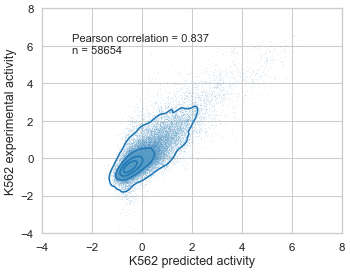

0.8444267426648074 0.7789476242228192


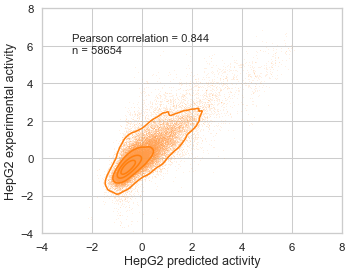

0.8337293967465286 0.768027472475985


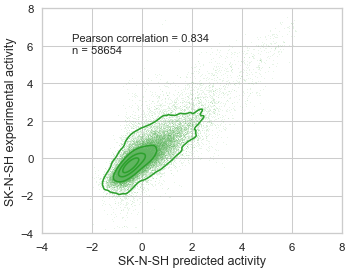

0.82045327442787 0.683316785807353


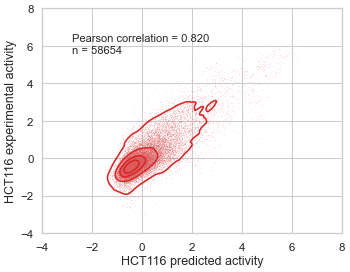

0.7292048912579565 0.6085010618670346


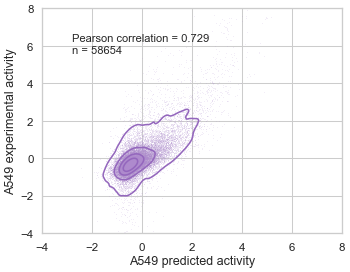

In [24]:
for i, cell_type in enumerate(cell_types):

    sns.set_theme(context='talk', style='whitegrid')
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)

    cond = data_split_dict[f'test']
    x = MPRA_df.loc[cond, f'{cell_type}_pred']
    y = MPRA_df.loc[cond, f'{cell_type}']
    r = pearson(x, y)[0]
    r2 = spearman(x, y)[0]
    print(r, r2)

    scatter = sns.scatterplot(x=x, y=y, s=1, alpha=0.3, color=tab20_colors[2*i])
    kde = sns.kdeplot(x=x, y=y, fill=False, levels=5, color=tab20_colors[2*i])
    
    plt.text(
        x=0.1, y=0.8, transform=scatter.transAxes, fontsize=16,
        s=f'Pearson correlation = {r:.3f} \nn = {len(x)}', 
    )

    plt.xlim(-4, 8)
    plt.ylim(-4, 8)
    plt.xlabel(f'{cell_type} predicted activity')
    plt.ylabel(f'{cell_type} experimental activity')
    plt.savefig(f'figures/Gosai_MPRA_Sei_{cell_type}_scatter.png', dpi=400)
    plt.show()

# plot acitiviy correlation across cell types

0.7853964427140129 0.6718794190415383


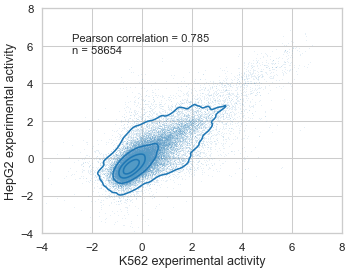

In [6]:
i = 0

sns.set_theme(context='talk', style='whitegrid')
plt.figure(figsize=(8, 6), dpi=50)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)

cond = data_split_dict[f'test']
x = MPRA_df.loc[cond, f'K562']
y = MPRA_df.loc[cond, f'HepG2']
r = pearson(x, y)[0]
r2 = spearman(x, y)[0]
print(r, r2)

scatter = sns.scatterplot(x=x, y=y, s=1, alpha=0.3, color=tab20_colors[2*i])
kde = sns.kdeplot(x=x, y=y, fill=False, levels=5, color=tab20_colors[2*i])

plt.text(
    x=0.1, y=0.8, transform=scatter.transAxes, fontsize=16,
    s=f'Pearson correlation = {r:.3f} \nn = {len(x)}', 
)

plt.xlim(-4, 8)
plt.ylim(-4, 8)
plt.xlabel(f'K562 experimental activity')
plt.ylabel(f'HepG2 experimental activity')
plt.savefig(f'figures/Gosai_MPRA_Sei_K562_HepG2_scatter.png', dpi=400)
plt.show()


760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
760679
total
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.801    0.759   0.825 0.724
HepG2   0.801  1.000    0.836   0.879 0.730
SK-N-SH 0.759  0.836    1.000   0.833 0.777
HCT116  0.825  0.879    0.833   1.000   NaN
A549    0.724  0.730    0.777     NaN 1.000
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
diff
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.478    0.454   0.524 0.565
HepG2   0.478  1.000    0.622   0.680 0.620
SK-N-SH 0.454  0.622    1.000   0.652 0.772
HCT116  0.524  0.680    0.652   1.000   NaN
A549    0.565  0.620    0.772     NaN 1.000
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
38034
22406
22406
22406
22406
22406
15975
15975
1597

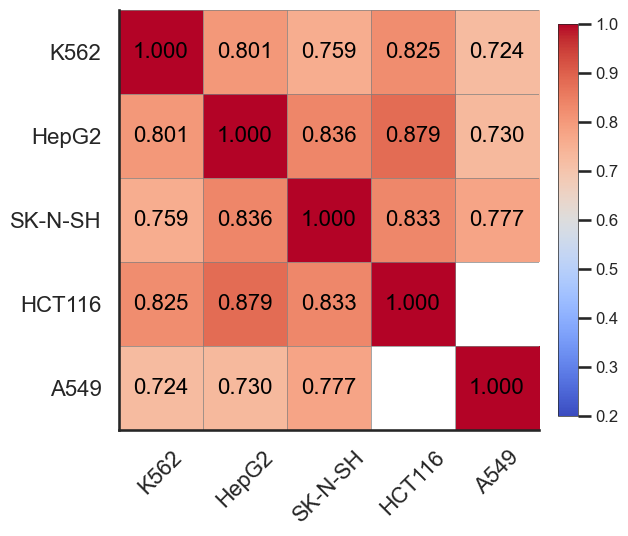

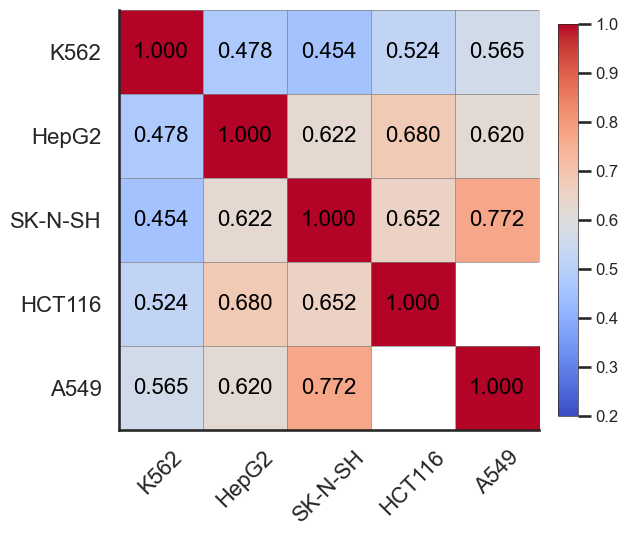

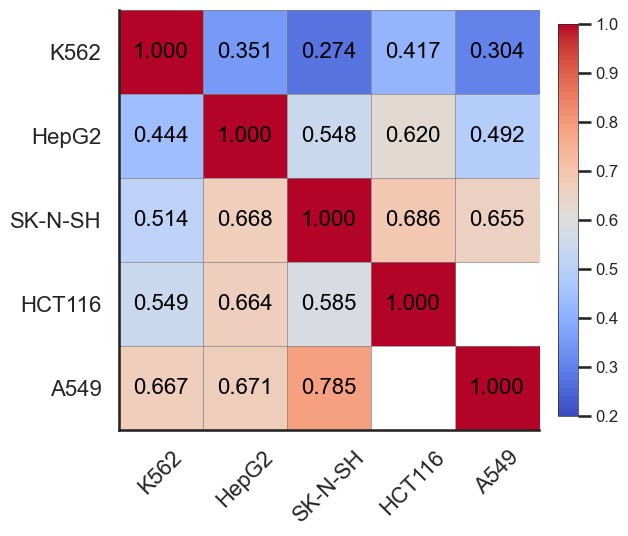

In [33]:
for data_split in ['total', 'diff', 'specific']:
    pearson_df = pd.DataFrame(dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            if data_split == 'specific':
                cond = data_split_dict[f'{cell_type}_{data_split}']
            else:
                cond = data_split_dict[data_split]
            x = MPRA_df.loc[cond, f'{cell_type}']
            y = MPRA_df.loc[cond, f'{cell_type_2}']
            print(len(x))
            r, p = pearson(x, y)
            pearson_df.loc[f'{cell_type}', f'{cell_type_2}'] = r
    pearson_df.loc['HCT116', 'A549'] = np.nan
    pearson_df.loc['A549', 'HCT116'] = np.nan
    print(data_split)
    print(pearson_df)

    data = np.array(pearson_df.values)
    row_labels = list(pearson_df.index)
    col_labels = list(pearson_df.columns)

    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
    im = ax.imshow(data, cmap='coolwarm', vmin=0.2, vmax=1.0)

    # 添加 colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.04)
    cbar.ax.tick_params(labelsize=12)
    cbar.outline.set_linewidth(0.5)

    # 添加文本注释（跳过 NaN）
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            if not np.isnan(val):
                ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='black', fontsize=16)

    # 设置坐标轴标签
    ax.set_xticks(np.arange(len(row_labels)))
    ax.set_yticks(np.arange(len(col_labels)))
    ax.set_xticklabels(row_labels, fontsize=16, rotation=45)
    ax.set_yticklabels(col_labels, fontsize=16)

    # 设置灰色网格线
    ax.set_xticks(np.arange(data.shape[1]+1)-0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-0.5, minor=True)
    ax.grid(which='minor', color='gray', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 自动布局和保存
    # plt.tight_layout()
    plt.savefig(f'figures/Gosai_MPRA_activity_vs_activity_{data_split}_heatmap.png', dpi=400)

# plot acitiviy vs pred correlation across cell types

total
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.837       0.771         0.770        0.799      0.786
HepG2        0.810       0.844         0.808        0.828      0.829
SK-N-SH      0.794       0.808         0.834        0.809      0.817
HCT116       0.809       0.813         0.796        0.820      0.807
A549         0.706       0.701         0.714        0.725      0.729
diff
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.757       0.577         0.605        0.644      0.612
HepG2        0.605       0.738         0.630        0.681      0.706
SK-N-SH      0.628       0.662         0.728        0.672      0.682
HCT116       0.687       0.710         0.688        0.749      0.718
A549         0.664       0.692         0.729        0.701      0.729
test
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.837       0.771         0.770        0.799      0.786
HepG2        0.810

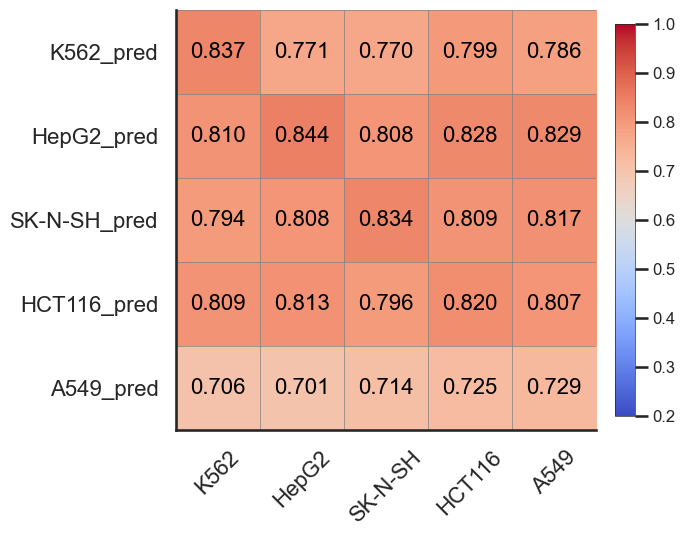

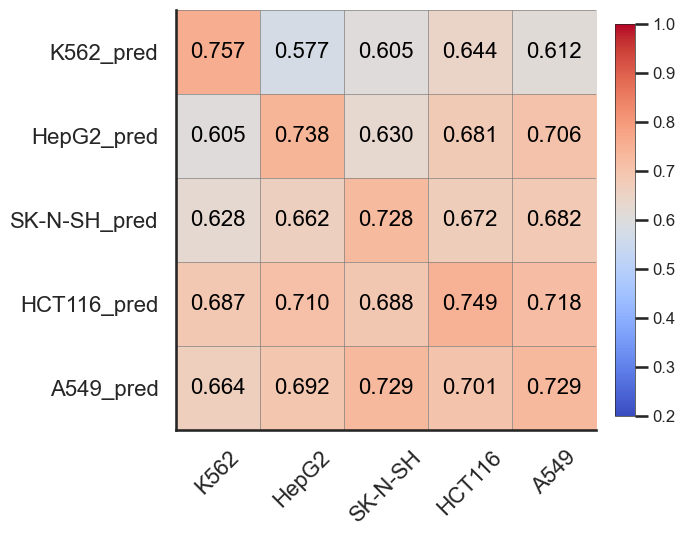

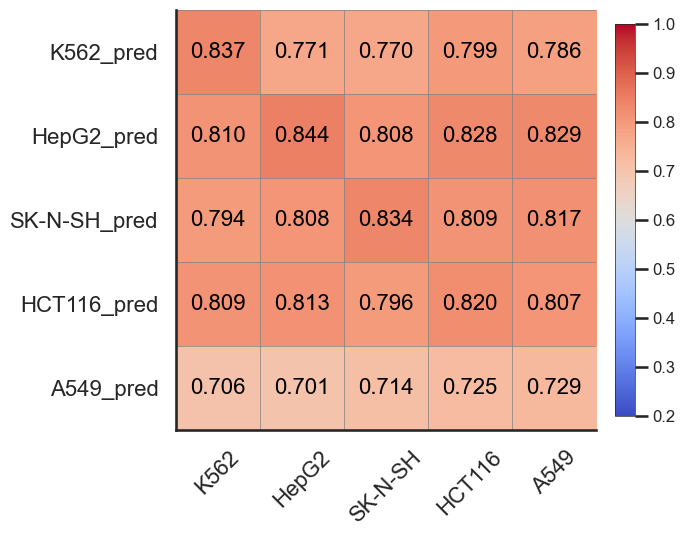

In [32]:
for data_split in ['total', 'diff', 'test']:
    pearson_df = pd.DataFrame(dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            cond_0 = data_split_dict['test']
            cond_1 = data_split_dict[data_split]
            cond = cond_0 & cond_1
            x = MPRA_df.loc[cond, f'{cell_type}']
            y = MPRA_df.loc[cond, f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            pearson_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    # pearson_df.loc['HCT116', 'A549_pred'] = np.nan
    # pearson_df.loc['A549', 'HCT116_pred'] = np.nan
    print(data_split)
    print(pearson_df)

    data = np.array(pearson_df.values)
    row_labels = list(pearson_df.index)
    col_labels = list(pearson_df.columns)

    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
    im = ax.imshow(data, cmap='coolwarm', vmin=0.2, vmax=1.0)

    # 添加 colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.04)
    cbar.ax.tick_params(labelsize=12)
    cbar.outline.set_linewidth(0.5)

    # 添加文本注释（跳过 NaN）
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            if not np.isnan(val):
                ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='black', fontsize=16)

    # 设置坐标轴标签
    ax.set_xticks(np.arange(len(row_labels)))
    ax.set_yticks(np.arange(len(col_labels)))
    ax.set_xticklabels(row_labels, fontsize=16, rotation=45)
    ax.set_yticklabels(col_labels, fontsize=16)

    # 设置灰色网格线
    ax.set_xticks(np.arange(data.shape[1]+1)-0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-0.5, minor=True)
    ax.grid(which='minor', color='gray', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 自动布局和保存
    # plt.tight_layout()
    plt.savefig(f'figures/Gosai_MPRA_activity_vs_pred_{data_split}_heatmap.png', dpi=400)

In [14]:
for data_split in ['train', 'test']:
    pearson_df = pd.DataFrame(dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}'] - df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)
            y = df[f'{cell_type_2}_pred'] - df[['K562_pred', 'HepG2_pred', 'SK-N-SH_pred']].mean(axis=1)
            r, p = pearson(x, y)
            pearson_df.loc[cell_type, f'{cell_type_2}_pred'] = r
    print(data_split)
    print(pearson_df)





train
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.640      -0.395        -0.304        0.025     -0.130
HepG2       -0.330       0.522        -0.156        0.040      0.104
SK-N-SH     -0.400      -0.035         0.469       -0.063      0.048
HCT116      -0.034       0.108        -0.068        0.146     -0.030
A549        -0.046      -0.074         0.125        0.141      0.198
test
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.546      -0.326        -0.251        0.034     -0.100
HepG2       -0.284       0.462        -0.157        0.041      0.100
SK-N-SH     -0.329      -0.070         0.412       -0.074      0.017
HCT116      -0.038       0.131        -0.088        0.134     -0.028
A549        -0.042      -0.069         0.113        0.130      0.199


In [22]:
# def quantile_normalize(df: pd.DataFrame) -> pd.DataFrame:
#     # 排序
#     sorted_df = pd.DataFrame(
#         np.sort(df.values, axis=0),
#         index=df.index,
#         columns=df.columns
#     )
    
#     # 计算每一行的平均（也就是所有列排序后对应rank位置的平均）
#     mean_ranks = sorted_df.mean(axis=1)
    
#     # 得到每列的排序索引
#     ranks = df.rank(method="min", axis=0).astype(int) - 1  # 0-based index
    
#     # 构建归一化后的结果矩阵
#     normed = df.copy()
#     for col in df.columns:
#         normed[col] = ranks[col].apply(lambda r: mean_ranks.iloc[r])
    
#     return normed

# cell_types = ['K562', 'HepG2', 'SK-N-SH']
# df[cell_types] = quantile_normalize(df[cell_types])

test
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.482      -0.193        -0.258        0.005     -0.053
HepG2       -0.200       0.425        -0.192        0.053      0.204
SK-N-SH     -0.309      -0.180         0.428       -0.052     -0.126
HCT116      -0.099       0.065         0.032        0.192      0.058
A549        -0.112       0.020         0.081        0.093      0.105


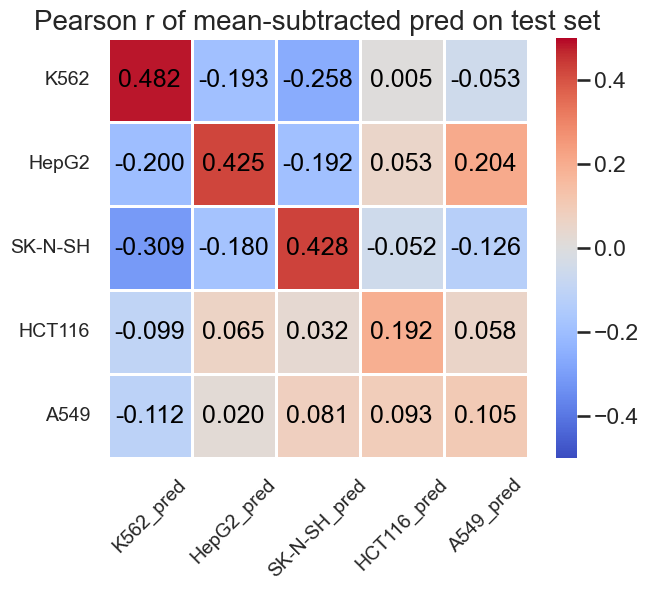

In [29]:
for data_split in ['test']:
    pearson_df = pd.DataFrame(dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            df = MPRA_df[condition]
            mean = df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)
            x = df[f'{cell_type}'] - df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)
            y = df[f'{cell_type_2}_pred'] - df[['K562_pred', 'HepG2_pred', 'SK-N-SH_pred']].mean(axis=1)
            r, p = pearson(x, y)
            pearson_df.loc[cell_type, f'{cell_type_2}_pred'] = r
    print(data_split)
    print(pearson_df)




plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=-0.5, vmax=0.5, 
            annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
        rotation=45, fontsize=14)
plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
        rotation=0, fontsize=14)
plt.title(f'Pearson r of mean-subtracted pred on test set', fontsize=20)
plt.grid(False)
plt.savefig(f'figures/Gosai_heatmap_pred-mean_{data_split}.png', dpi=400)
plt.show()

specific
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.268    0.188   0.331 0.212
HepG2   0.304  1.000    0.371   0.486 0.390
SK-N-SH 0.425  0.603    1.000   0.620 0.614
HCT116  0.388  0.547    0.425   1.000 0.723
A549    0.685  0.677    0.789   0.836 1.000


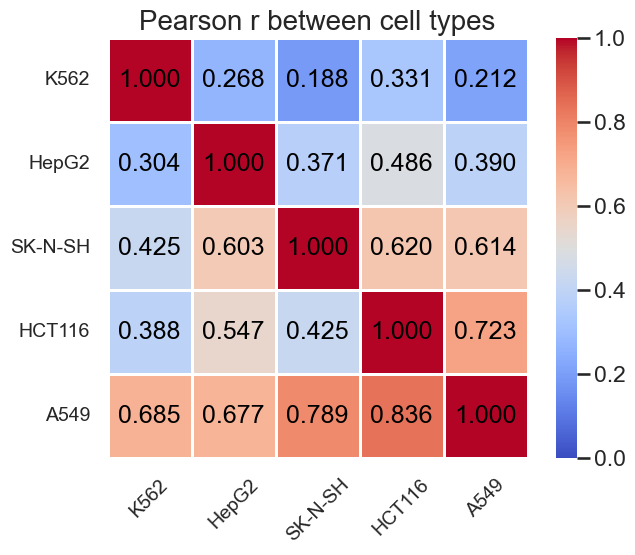

In [6]:

pearson_df = pd.DataFrame(dtype=float)
for cell_type in cell_types:
    for cell_type_2 in cell_types:
        condition_1 = data_split_dict['total']
        condition_2 = data_split_dict[f'{cell_type}_specific']
        df = MPRA_df[condition_1 & condition_2]
        x = df[f'{cell_type}']
        y = df[f'{cell_type_2}']
        r = pearson(x, y)[0]
        pearson_df.loc[cell_type, cell_type_2] = r
print('specific')
print(pearson_df)


# pearson_df = pd.DataFrame(dtype=float)
# for cell_type in cell_types:
#     for cell_type_2 in cell_types:
#         condition_1 = data_split_dict['test']
#         condition_2 = data_split_dict[f'{cell_type}_specific']
#         df = MPRA_df[condition_1 & condition_2]
#         x = df[f'{cell_type}']
#         y = df[f'{cell_type_2}']
#         r = pearson(x, y)[0]
#         pearson_df.loc[cell_type, cell_type_2] = r
# print('test+specific')
# print(pearson_df)



plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
            annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
        rotation=45, fontsize=14)
plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
        rotation=0, fontsize=14)
plt.title(f'Pearson r between cell types', fontsize=20)
plt.grid(False)
plt.savefig(f'figures/Gosai_heatmap_activity_pearson_{data_split}.png', dpi=400)
plt.show()

test+specific
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.577       0.384         0.411        0.424      0.411
HepG2        0.542       0.669         0.541        0.590      0.646
SK-N-SH      0.612       0.588         0.707        0.614      0.609
HCT116       0.491       0.512         0.478        0.601      0.547
A549         0.714       0.735         0.739        0.754      0.746


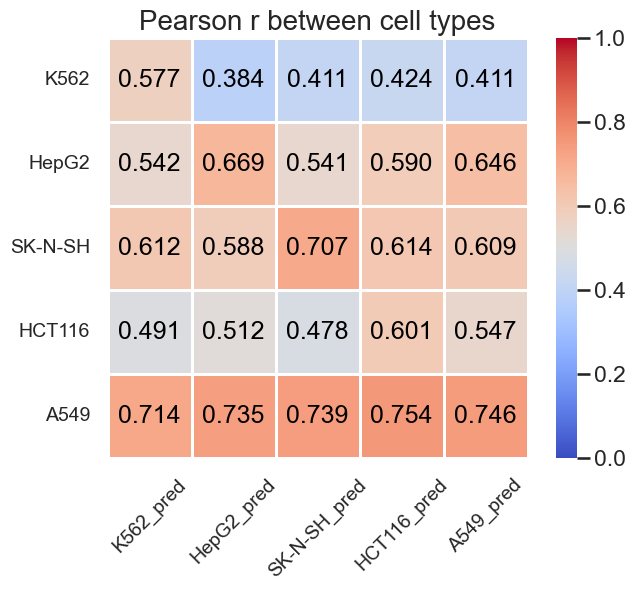

In [49]:

# pearson_df = pd.DataFrame(dtype=float)
# for cell_type in cell_types:
#     for cell_type_2 in cell_types:
#         condition_1 = data_split_dict['total']
#         condition_2 = data_split_dict[f'{cell_type}_specific']
#         df = MPRA_df[condition_1 & condition_2]
#         x = df[f'{cell_type}']
#         y = df[f'{cell_type_2}_pred']
#         r = pearson(x, y)[0]
#         pearson_df.loc[cell_type, cell_type_2] = r
# print('specific')
# print(pearson_df)


pearson_df = pd.DataFrame(dtype=float)
for cell_type in cell_types:
    for cell_type_2 in cell_types:
        condition_1 = data_split_dict['test']
        condition_2 = data_split_dict[f'{cell_type}_specific']
        df = MPRA_df[condition_1 & condition_2]
        x = df[f'{cell_type}']
        y = df[f'{cell_type_2}_pred']
        r = pearson(x, y)[0]
        pearson_df.loc[cell_type, f'{cell_type_2}_pred'] = r
print('test+specific')
print(pearson_df)



plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
            annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
        rotation=45, fontsize=14)
plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
        rotation=0, fontsize=14)
plt.title(f'Pearson r between cell types', fontsize=20)
plt.grid(False)
plt.savefig(f'figures/Gosai_heatmap_pred_activity_pearson_test_specific.png', dpi=400)
plt.show()

total
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.801    0.759   0.825 0.724
HepG2   0.801  1.000    0.836   0.879 0.730
SK-N-SH 0.759  0.836    1.000   0.833 0.777
HCT116  0.825  0.879    0.833   1.000 0.825
A549    0.724  0.730    0.777   0.825 1.000


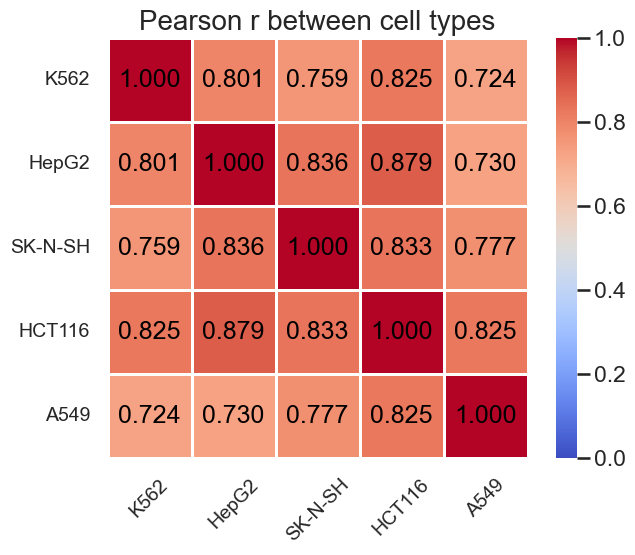

diff
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.471    0.453   0.516 0.561
HepG2   0.471  1.000    0.622   0.675 0.617
SK-N-SH 0.453  0.622    1.000   0.649 0.771
HCT116  0.516  0.675    0.649   1.000 0.821
A549    0.561  0.617    0.771   0.821 1.000


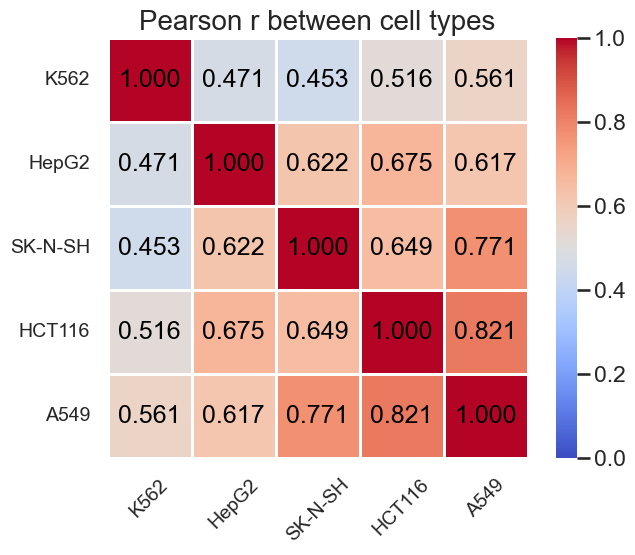

In [37]:
for data_split in ['total', 'diff']:
    pearson_df = pd.DataFrame(dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            if data_split == 'specific' or data_split == 'high':
                condition = data_split_dict[f'{cell_type}_{data_split}']
            else:
                condition = data_split_dict[data_split]

            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}']
            r = pearson(x, y)[0]
            pearson_df.loc[cell_type, cell_type_2] = r
    print(data_split)
    print(pearson_df)

    # pearson_df.loc['HCT116', 'A549'] = np.nan
    # pearson_df.loc['A549', 'HCT116'] = np.nan


    plt.figure(figsize=(8, 6), dpi=100)
    # plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
    sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
                annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
    plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
            rotation=45, fontsize=14)
    plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
            rotation=0, fontsize=14)
    plt.title(f'Pearson r between cell types', fontsize=20)
    plt.grid(False)
    plt.savefig(f'figures/Gosai_heatmap_activity_pearson_{data_split}.png', dpi=400)
    plt.show()

test
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.817       0.781         0.787        0.793      0.789
HepG2        0.834       0.851         0.832        0.836      0.842
SK-N-SH      0.800       0.796         0.821        0.797      0.795
HCT116       0.817       0.817         0.815        0.824      0.815
A549         0.710       0.710         0.717        0.727      0.729


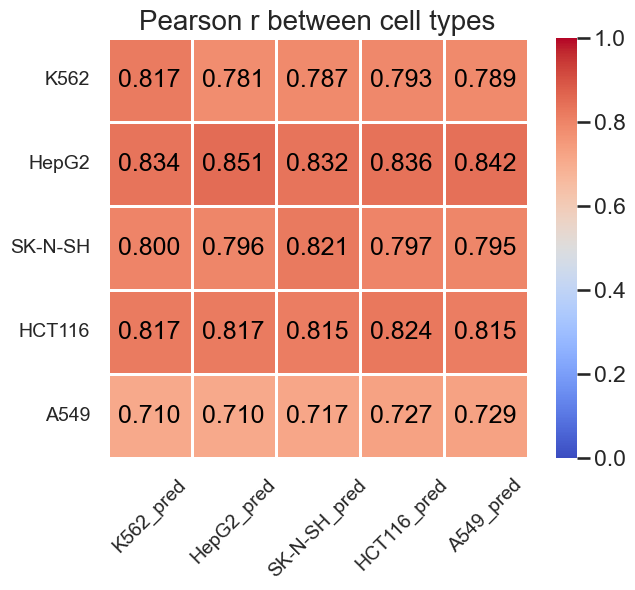

test_diff
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.708       0.570         0.611        0.608      0.592
HepG2        0.661       0.748         0.677        0.695      0.726
SK-N-SH      0.627       0.608         0.704        0.643      0.628
HCT116       0.696       0.684         0.698        0.742      0.701
A549         0.660       0.695         0.714        0.706      0.705


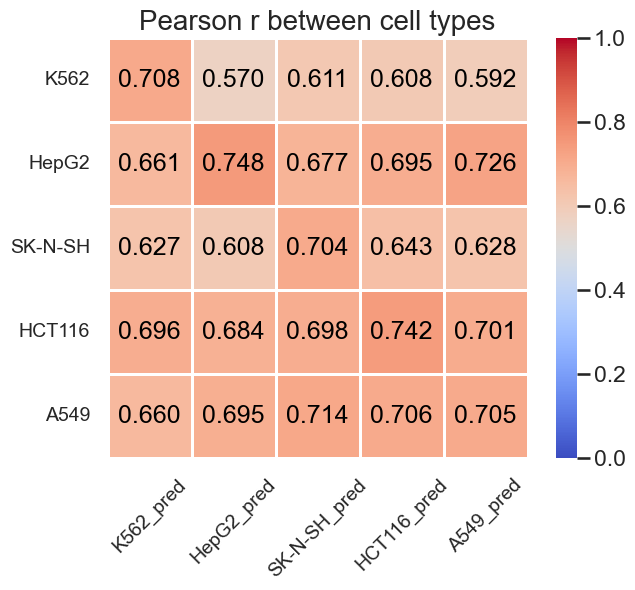

In [38]:
for data_split in ['test', 'test_diff']:
    pearson_df = pd.DataFrame(dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            if data_split == 'specific' or data_split == 'high':
                condition = data_split_dict[f'{cell_type}_{data_split}']
            else:
                condition = data_split_dict[data_split]

            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r = pearson(x, y)[0]
            pearson_df.loc[cell_type, f'{cell_type_2}_pred'] = r
    print(data_split)
    print(pearson_df)

    # pearson_df.loc['HCT116', 'A549'] = np.nan
    # pearson_df.loc['A549', 'HCT116'] = np.nan


    plt.figure(figsize=(8, 6), dpi=100)
    #plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
    sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=0.0, vmax=1, 
                annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
    plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
            rotation=45, fontsize=14)
    plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
            rotation=0, fontsize=14)
    plt.title(f'Pearson r between cell types', fontsize=20)
    plt.grid(False)
    plt.savefig(f'figures/Gosai_heatmap_pred_activity_pearson_{data_split}.png', dpi=400)
    plt.show()